In [175]:
from scipy.optimize import minimize
import matplotlib as mpl
import numpy as np
import pandas as pd
import multiprocessing as mp
import shelve
from workers import vary_rv_worker
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.integrate import solve_ivp

from helper import mse, lotka_volterra, int_cost_lotka_volterra, get_predator_prey_data

t, y = get_predator_prey_data()

In [101]:
def sp_confidence_interval(samples, p=0.95):
    """ Calculates the confidence interval (with p=95% unless noted otherwise) 
    Returns:
         Confidence radius (int) based on samples.     
    """
    a = stats.t.interval(p, df=len(samples)-1, loc=np.mean(samples), scale=stats.sem(samples))
    return a[1] - a[0]

In [102]:
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 12

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"""
     \usepackage{palatino}
     \usepackage{newpxmath}""")
    
plt.rc("font", family="serif")

In [103]:
xs = np.array([
    [0.66593614, 2.94213991, 8.129154  , 4.88824876], #10
    [1.59035578, 3.964897  , 8.93986609, 2.72514184], #9
    [2.91245287, 2.70612094, 2.01560385, 1.47317489], # good guess (MSE ~ 3.4)
])

if True:
    shelf = shelve.open("Arrays/hc_costs")
    hc_costs = []
    hc_states = []
    
    for x0 in xs:
        res = minimize(int_cost_lotka_volterra, x0, method="nelder-mead", args=(y, t),
                       options={"xatol": 1e-8})
        print(res)
        x_opt = res.x
        hc_states.append(x_opt)
        cost = int_cost_lotka_volterra(x_opt, y, t)
        hc_costs.append(cost)
    
    shelf["hc_costs"] = hc_costs
    shelf["hc_states"] = hc_states
    shelf.close()

/home/soud/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 final_simplex: (array([[0.68922899, 2.7876918 , 7.97854659, 5.2028389 ],
       [0.68922899, 2.7876918 , 7.97854659, 5.2028389 ],
       [0.68922898, 2.7876918 , 7.97854659, 5.20283891],
       [0.68922898, 2.7876918 , 7.97854659, 5.20283891],
       [0.68922898, 2.7876918 , 7.97854659, 5.20283891]]), array([8.72820764, 8.72821005, 8.72821038, 8.72821291, 8.72821368]))
           fun: 8.728207644490762
       message: 'Optimization terminated successfully.'
          nfev: 294
           nit: 124
        status: 0
       success: True
             x: array([0.68922899, 2.7876918 , 7.97854659, 5.2028389 ])
 final_simplex: (array([[1.00686295, 0.74605038, 0.67382367, 0.67967261],
       [1.01721452, 0.73702627, 0.66676839, 0.66629397],
       [1.06628233, 0.7662262 , 0.66460585, 0.64916939],
       [1.0604856 , 0.78076301, 0.69486844, 0.66581218],
       [1.04693022, 0.74386811, 0.62776529, 0.64087017]]), array([6.44260225, 6.44767762, 6.45262109, 6.45330167, 6.45367533]))
           fu

In [56]:
shelf = shelve.open("Arrays/hc_costs")
hc_costs = shelf["hc_costs"]
hc_states = shelf["hc_states"] 
shelf.close() 

In [57]:
xs

array([[0.66593614, 2.94213991, 8.129154  , 4.88824876],
       [1.59035578, 3.964897  , 8.93986609, 2.72514184],
       [2.91245287, 2.70612094, 2.01560385, 1.47317489]])

In [58]:
for j, x in enumerate(xs):
    print(f"\\vec{{s}}^{{{(j+1)}}}_0 = \\begin{{pmatrix}}", end="")
    for k, i in enumerate(x):
        print(f"{i:.3f}", end="")
        if k != len(x)-1:
            print(" & ", end="")
    print("\\end{pmatrix}", end="")
    print("")

\vec{s}^{1}_0 = \begin{pmatrix}0.666 & 2.942 & 8.129 & 4.888\end{pmatrix}
\vec{s}^{2}_0 = \begin{pmatrix}1.590 & 3.965 & 8.940 & 2.725\end{pmatrix}
\vec{s}^{3}_0 = \begin{pmatrix}2.912 & 2.706 & 2.016 & 1.473\end{pmatrix}


In [59]:
hc_costs

[8.728207644490762, 6.44260224770719, 0.019249604764674508]

In [60]:
for cost in hc_costs:
    print(f"{cost:.3f}")

8.728
6.443
0.019


In [61]:
def vary_rv(rvs, n_sim=50, T_start=200, T_steps=2000):
    manager = mp.Manager()
    costs = manager.list()
    states = manager.list()

    work_queue = mp.Queue()
    for i, rv in enumerate(rvs):
        costs.append(manager.list())
        states.append(manager.list())
        for _ in range(n_sim):
            work_queue.put((i, rv))

    processes = []

    for i in range(mp.cpu_count()):
        p = mp.Process(target=vary_rv_worker, args=(
            work_queue, costs, states, T_start, T_steps, t, y
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return [list(t) for t in costs], [list(t) for t in states]

In [74]:
%%time

if False:
    shelf = shelve.open("Arrays/sa_costs")
    np.random.seed(0o37663)
    sa_costs, sa_states = vary_rv(xs, n_sim=500, T_start=200, T_steps=2000)
    shelf["sa_costs"] = sa_costs
    shelf["sa_states"] = sa_states
    shelf.close()

/home/soud/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/soud/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/soud/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/soud/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintW

CPU times: user 272 ms, sys: 115 ms, total: 387 ms
Wall time: 49min 24s


In [75]:
shelf = shelve.open("Arrays/sa_costs")
sa_costs = np.array(shelf["sa_costs"])
sa_states = np.array(shelf["sa_states"])
shelf.close() 

In [132]:
print(np.mean(sa_costs, axis=1))
print(np.median(sa_costs, axis=1))
print(np.min(sa_costs, axis=1))
print(np.max(sa_costs, axis=1))

[3.37286671 3.28903312 1.55793182]
[0.77401884 0.39131021 0.13686531]
[0.02416202 0.02590782 0.02934549]
[8.2449789  8.24503211 8.36899454]


In [77]:
print([sp_confidence_interval(samples) for samples in sa_costs])

[0.6002226371456683, 0.6074107240960922, 0.4785098358451436]


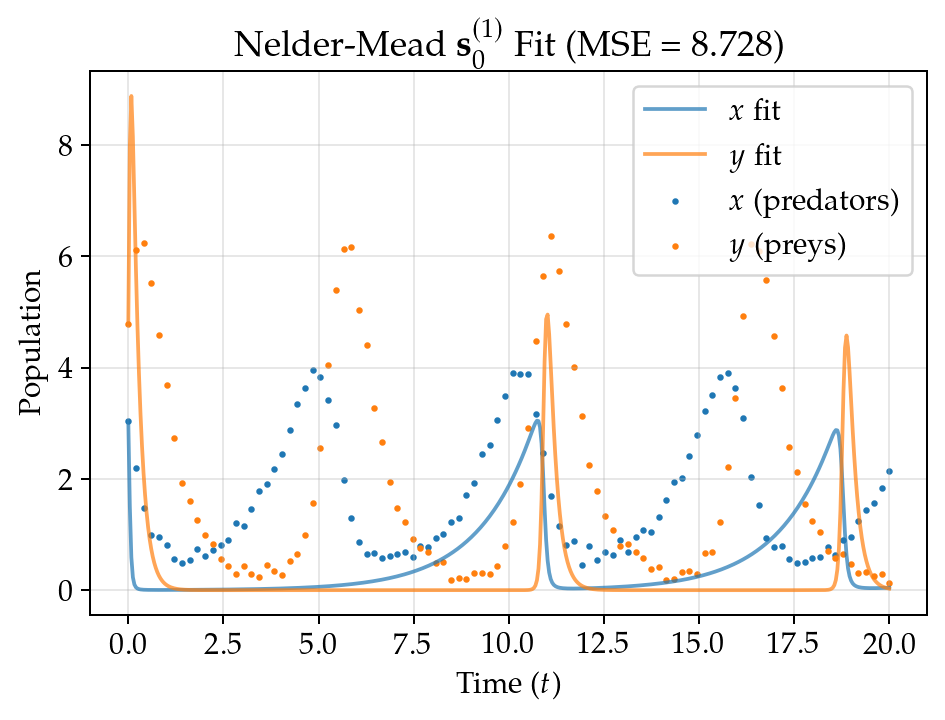

[0.68922899 2.7876918  7.97854659 5.2028389 ]
8.728207644490762


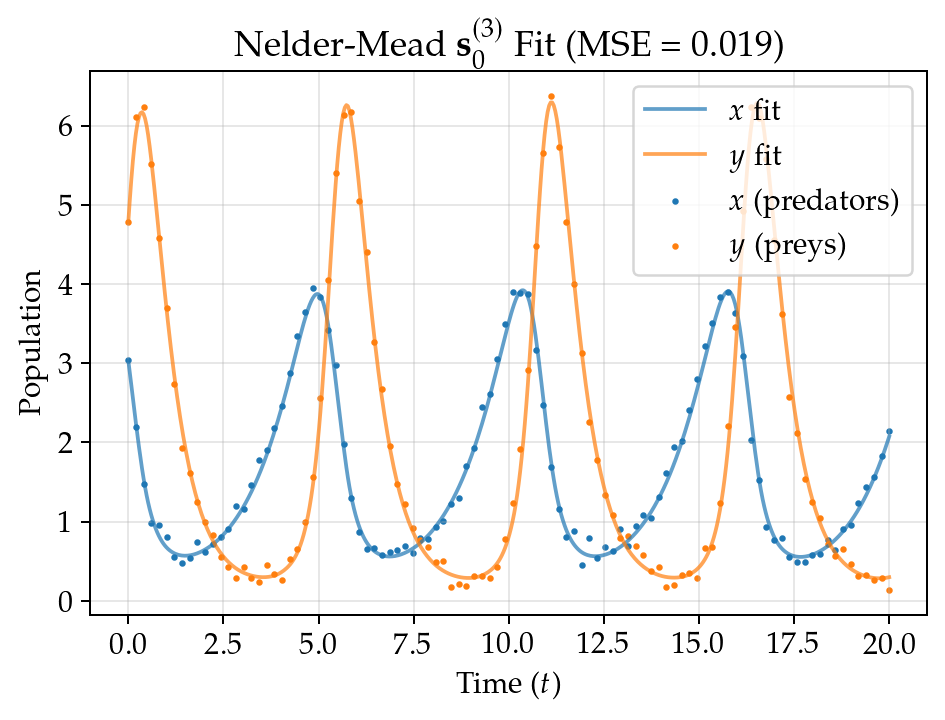

[0.85688184 0.43839553 1.16138458 2.00719186]
0.019249604764674508


In [183]:
s1_state_hc = (hc_states[0], hc_costs[0], 1)
s3_state_hc = (hc_states[2], hc_costs[2], 3)

for x, mse, i in (s1_state_hc, s3_state_hc):
    sol_opt = solve_ivp(lotka_volterra, (t[0], t[-1]), y[0], args=x, dense_output=True)
    z_opt = sol_opt.sol(t)
    ts = np.linspace(t[0], t[-1], 500)
    z = sol_opt.sol(ts)
    plt.plot(ts, z[0], label="$x$ fit", alpha=0.7)
    plt.plot(ts, z[1], label="$y$ fit", alpha=0.7)
    plt.scatter(t, y[:,0], s=2.5, label="$x$ (predators)")
    plt.scatter(t, y[:,1], s=2.5, label="$y$ (preys)")
    plt.ylabel("Population")
    plt.xlabel("Time ($t$)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.title(f"Nelder-Mead $\\mathbf{{s}}_0^{{({i})}}$ Fit (MSE = ${mse:.3f}$)")
    plt.savefig(f"figures/nm_s{i}_fit.pdf", bbox_inches="tight")
    plt.show()
    print(x)
    print(mse)

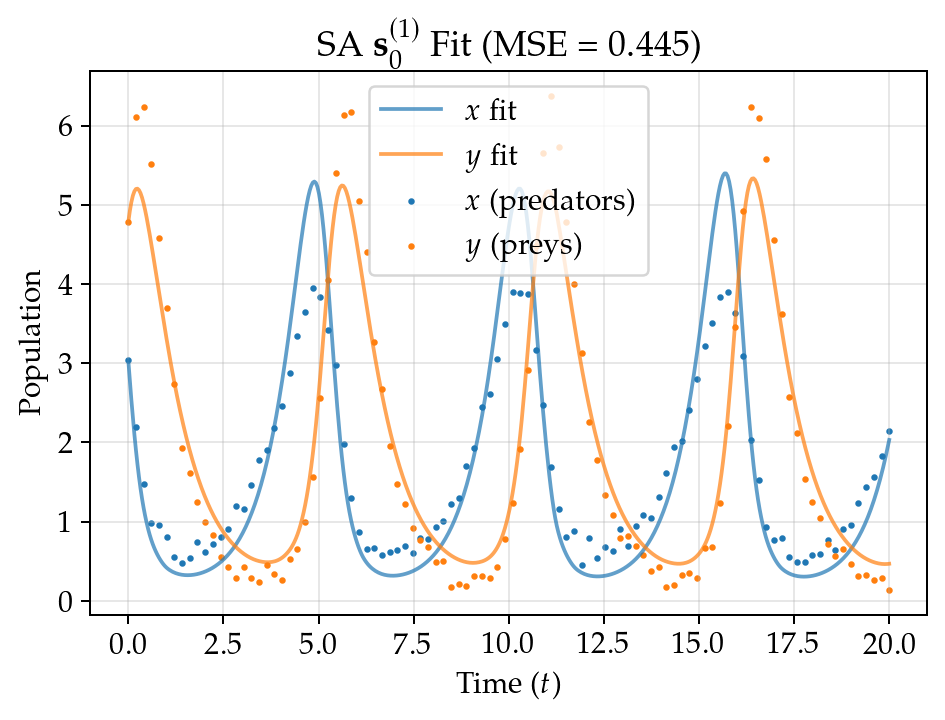

[1.52994016 0.7637773  0.63700394 1.13488955]
0.44512676383344696


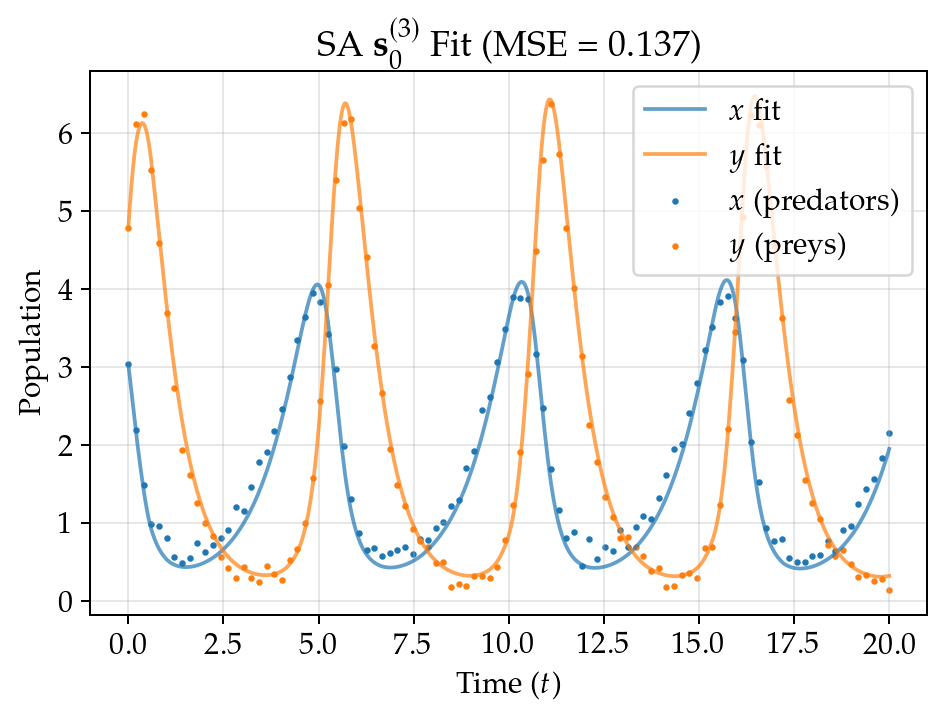

[1.02374111 0.50267306 1.05933837 1.71651254]
0.1368133133588896


In [184]:
s1_sorted = np.argsort(sa_costs[0])
s1_median_idx = s1_sorted[len(sa_costs[0])//2 - 1]
s3_sorted = np.argsort(sa_costs[2])
s3_median_idx = s3_sorted[len(sa_costs[2])//2 - 1]

s1_state_sa = (sa_states[0][s1_median_idx], sa_costs[0][s1_median_idx], 1)
s3_state_sa = (sa_states[2][s3_median_idx], sa_costs[2][s3_median_idx], 3)

for x, mse, i in (s1_state_sa, s3_state_sa):
    sol_opt = solve_ivp(lotka_volterra, (t[0], t[-1]), y[0], args=x, dense_output=True)
    z_opt = sol_opt.sol(t)
    ts = np.linspace(t[0], t[-1], 500)
    z = sol_opt.sol(ts)
    plt.plot(ts, z[0], label="$x$ fit", alpha=0.7)
    plt.plot(ts, z[1], label="$y$ fit", alpha=0.7)
    plt.scatter(t, y[:,0], s=2.5, label="$x$ (predators)")
    plt.scatter(t, y[:,1], s=2.5, label="$y$ (preys)")
    plt.ylabel("Population")
    plt.xlabel("Time ($t$)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.title(f"SA $\\mathbf{{s}}_0^{{({i})}}$ Fit (MSE = ${mse:.3f}$)")
    plt.savefig(f"figures/sa_s{i}_fit.pdf", bbox_inches="tight")
    plt.show()
    print(x)
    print(mse)

In [137]:
sa_costs[0][s1_median_idx], sa_costs[2][s3_median_idx]

(1.1029109179867536, 0.13691730641250344)

In [138]:
s1_state_x_sa = sa_states[0][s1_median_idx]
s3_state_x_sa = sa_states[0][s3_median_idx]

In [78]:
values_sa = np.array(sa_costs.flatten())
values_hc = np.array(hc_costs)
data_sa = np.array([np.repeat("SA", len(values_sa)), values_sa])
data_hc = np.array([np.repeat("Nelder-Mead", len(values_hc)), values_hc])
Data = np.concatenate([data_sa], axis = 1)

df = pd.DataFrame(Data.T, columns = ["Optimizer", "MSE"])
df = df.astype({"MSE": float})

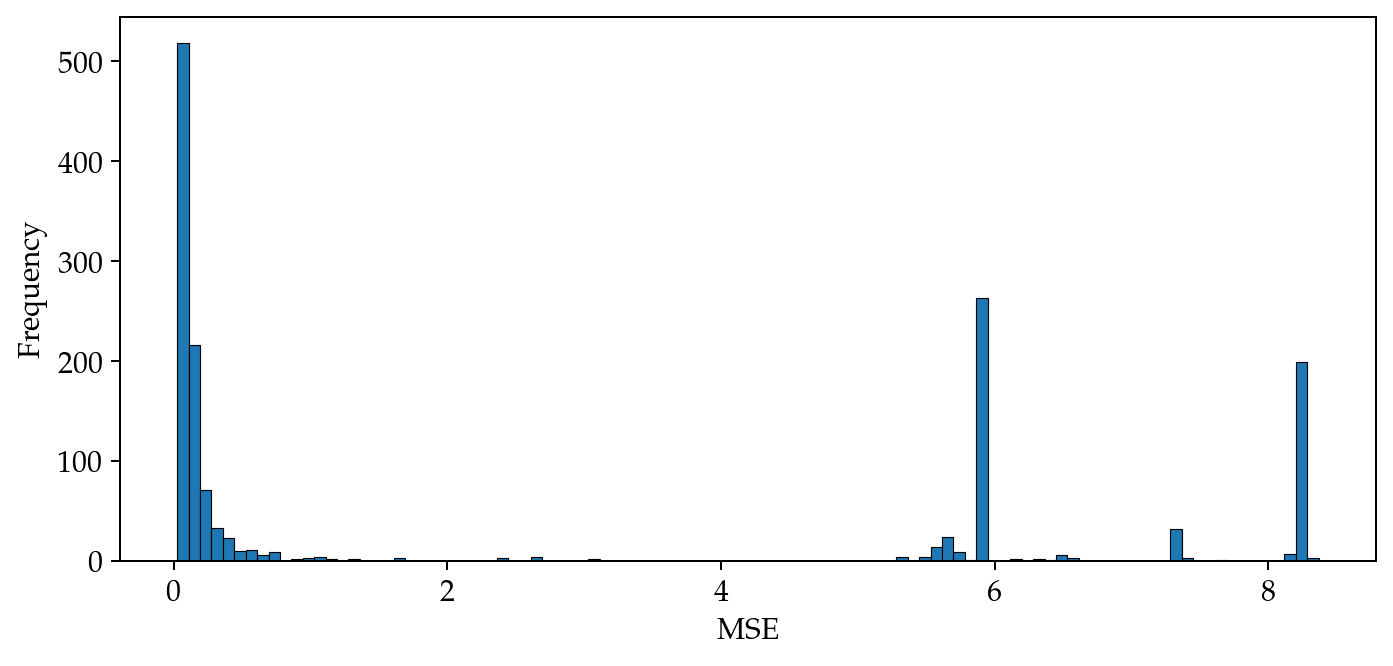

In [99]:
plt.figure(figsize=(9, 4))
g = sns.histplot(data=df, hue="Optimizer", x="MSE", alpha=1, bins=100)
plt.legend([],[], frameon=False)
plt.ylabel("Frequency")
plt.savefig("figures/mse_freq_sa.pdf", bbox_inches="tight")
plt.show()